## Setup

To get started with walkingcalculatr (Python), a Python environment (Python >= 3.8) must be set up with the required dependencies.
 
### Local Environment

Create a python environment in the terminal called **wc8r_env**:

> python -m venv wc8r_env\
> source wc8r_env/bin/activate

Within the environment, install required dependencies (as of August 2024) listed in **requirement.txt** or using **pip install**:

> pip install -r requirements.txt\
**OR**\
> pip install ipykernel ipython pandas polars numpy path datetime pygris geopandas osmnx matplotlib pyarrow census us

To add your environment to a Jupyter kernel, run the following:
> ipython kernel install --user --name=wc8r_env

Within the Jupyter notebook, the added environment/kernel can be connected via `kernel > change kernel`.
After connecting to the **wc8r_env** kernel, we can import our required modules and functions for walk extraction as follows:

In [2]:
from utils import *

### Troubleshooting

#### OSMNX / Requests (SSL error)

The OSMNX package uses the **requests** package in Python which may run into SSL verification errors if the proper certifications are not added. The following code can be used to find the location of SSL certifications which should be updated accordingly. 

In [14]:
import certifi
import ssl
cert_loc = certifi.where()
ctx = ssl._create_unverified_context(cafile=cert_loc)

If the SSL certification is unable to be updated, the requests package (for OSMNX) can be bypassed by setting `verify = False` as shown below (not recommended).

In [ ]:
ox.settings.requests_kwargs = {'verify': False}

## 1. Reading in the Raw LBS Data

In [16]:
# Read in csv or parquet
SAMPLE_DATA = "../data-raw/synthetic_ness_data.csv.gz"
df = pl.read_csv(SAMPLE_DATA)

In [4]:
# Cast userID to categorical type
df = df.with_columns(id = pl.col('id').cast(pl.Utf8))

In [ ]:
df.head()

## 2. Extracting Walks

In [5]:
# Calculate walks
walks_df, record_counter = ExtractWalks(df)

['id', 'latitude', 'longitude', 'unix_timestamp', 'horizontal_accuracy']


/hawes/projects/PA-DEV/CDCENT/walkingcalculatr/Python/utils.py:215: CategoricalRemappingWarning: Local categoricals have different encodings, expensive re-encoding is done to perform this merge operation. Consider using a StringCache or an Enum type if the categories are known in advance
  dfclean = df.select(pl.col("id").str.to_lowercase().cast(pl.Categorical).alias('userId'),


In [6]:
# Show output
walks_df.head()

userId,walkNum,lat,lon,time,accuracy,dist,vel,angle
cat,i64,f64,f64,i32,f64,f64,f64,f64
"""4""",17,38.45277,-99.899773,1625270606,0.0,NaN,NaN,NaN
"""4""",17,38.457062,-99.896179,1625271310,0.0,571.275837,0.811471,0.390621
"""4""",17,38.454128,-99.901657,1625271972,0.0,578.507136,0.873878,0.0
"""4""",20,38.45277,-99.904449,1625542386,0.0,NaN,NaN,NaN
"""4""",20,38.457088,-99.896248,1625543147,0.0,861.541232,1.132117,0.409166


In [7]:
print(walks_df.select('walkNum').unique().shape[0], walks_df.select('userId').unique().shape[0])

649 329


In [8]:
# Cast polars to pandas dataframe
walks_df = walks_df.to_pandas()

## 3. Extracting Walkable Area Features by Census Tract

Walkable areas are areas within census tracts such as parks, sidewalks, and footpaths which are identified and extracted from OpenStreetMaps (OSM). More information on the type of attributes available through OSM can be found [here](https://wiki.openstreetmap.org/wiki/Key:highway).

To determine those walks within defined "walkable" areas, we
can run the following `get_walkable_areas()` to get walkable areas from OSM for census tracts in __Ness, KS__. The **fill_size** parameter is the maximum area of holes to be removed from polygon.

In [9]:
tract_area_lst = get_walkable_areas(county_name = 'Ness', county_state = 'KS',  year = 2023, fill_size = 200E-6)

Using FIPS code '20' for input 'KS'
Using FIPS code '20' for input 'KS'


/hawes/projects/PA-DEV/CDCENT/walkingcalculatr/Python/utils.py:535: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  county_tracts['buffer_geometry'] = county_tracts['geometry'].buffer(500E-5)


<Axes: >

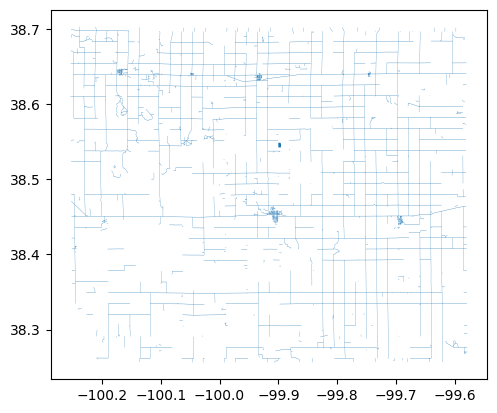

In [10]:
# Plot walkable areas
tract_area_lst.geometry.plot()

## 4. Checking if Extracted Walk Trips are in Walkable Areas

Given the walkable shapefiles generated, we can find determine which walks have a defined threshold percentage of pings within walkable areas. When defining walks in walkable areas as walks that have 75% of their pings in the walkable areas found in `get_walkable_areas()`, the resulting dataset gives us 561 unique walks.

In [11]:
walks_in_walkable = get_walkable(walks_df, tract_area_lst)

In [12]:
# Filter to walks given a certain threshold
final_walks = walks_in_walkable[walks_in_walkable.pct_walkable > 0.75].reset_index(drop = True)

We can then get a general metric summary of the resulting data. 
From the below table, you can see that the `total_walks_in_walkable_areas` for Ness County, KS is 566.

In [13]:
num_walks = len(walks_df['walkNum'].unique())
num_walks_in_walkable = len(final_walks.walkNum.unique())
num_pings = final_walks.shape[0]
num_devices = len(final_walks.userId.unique())

summary_df = pd.DataFrame([num_walks, num_walks_in_walkable, num_pings, num_devices], 
                          index = ['Number of Walks',  'Number of Walks in Walkable Areas',  'Number of Pings', 'Number of Devices'], 
                          columns = ['Count'])
summary_df

,Count
Number of Walks,649
Number of Walks in Walkable Areas,566
Number of Pings,1889
Number of Devices,301
